In [51]:
import pandas as pd
import numpy as np

from dateutil.parser import parse
from datetime import datetime
import dateutil.parser

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


import glob
import os
import zipfile

import timeit

import re
import urllib

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy


import statsmodels.api as sm

In [ ]:
def find_console_tags(soup):
    # Console tags are stored as images, so we find the image tag and record its 'alt' value as text
    consoles = list()
    for img in soup.find_all('img'):
        if 'images/consoles'in img['src']:
            # Cut file path elements from string
            console_tag = (img['src'][17:-6])
            consoles.append(img['alt'])
    return consoles


# Find the names of games from the links
def find_names_column(table_path):
    names_list = list()
    for row in table_path.xpath('.//tr'):
        for td in row.xpath('.//td'):
            if not td.find('a') is None:
                names_list.append(td.find('a').text.strip()) 
    return names_list

# Write a function that takes in a VGChartz URL and gives us all the data in their video game database
def scrape_vgchartz_videogame_db_page(url):
    
    response = requests.get(url)

    ### Check the Status
    assert(response.status_code == 200)," Website not OK " # status code = 200 => OK
    
    #Store the contents of the website under doc
    page=response.text
    soup = BeautifulSoup(page, "lxml")
    doc = lh.fromstring(response.content)
    
    # Selects the table with all the data in it on HTML using xpath
    target_table_path = doc.xpath('//*[@id="generalBody"]/table')[0]

    # Find column values that won't be scraped correctly with .text option
    names_list = find_names_column(target_table_path)
    consoles = find_console_tags(soup)
    
    # Parse non-image and non-URL info from the data table to a pandas DataFrame
    row_dict={}
    df=pd.DataFrame()
    row_list= list()
    for counter,row in enumerate(target_table_path.xpath(".//tr")):
        if counter > 2: # To skip header rows
            row_list=[td.text for td in row.xpath(".//td")]
            row_dict[counter] = row_list

    df=pd.DataFrame.from_dict(row_dict).transpose()
    df.columns = ['position','game','blank','console','publisher','developer','vgchart_score',\
                 'critic_score','user_score','total_shipped','total_sales',\
                  'na_sales','pal_sales','japan_sales','other_sales',\
                  'release_date','last_update']
    
    # Correct the console and game columns using scraped values
    
    df=df.reset_index().drop(columns = ['index','blank'])
    df['console'] = consoles
    df['game'] = names_list
    return df

    # We can 'hack' the URL to display any number of results per page. I'll leave it as an argument.
def scrape_all_vg_chartz_videogame_db(results_per_page):
    df = pd.DataFrame()
    current_page = 1
    games_left = True
    while games_left:
        url = 'http://www.vgchartz.com/games/games.php?page=' + str(current_page) +\
        '&results=' + str(results_per_page) + '&name=&console=&keyword=&publisher=&genre=&order=Sales&ownership\
        =Both&boxart=Both&banner=Both&showdeleted=&region=All&goty_year=&developer=&direction\
        =DESC&showtotalsales=1&shownasales=1&showpalsales=1&showjapansales=1&showothersales=1&\
        showpublisher=1&showdeveloper=1&showreleasedate=1&showlastupdate=1&showvgchartzscore=1&\
        showcriticscore=1&showuserscore=1&showshipped=1&alphasort=&showmultiplat=No'
        new_df = scrape_vgchartz_videogame_db_page(url)
        df = df.append(new_df)

        #REMOVE LATER, TEST CONDIITON
      #  if current_page > 3:
       #     games_left = False
        print('Scraped page: ',current_page)
        if new_df.shape[0] < results_per_page:
            games_left = False
        current_page +=1
    print('Scraping done!')
    print('Total rows parsed = ', df.shape[0])
    return df.reset_index().drop(columns = 'index')

# Run the code to scrape! I did 10,000 rows per page to speed things up.
df=scrape_all_vg_chartz_videogame_db(10000)

# Compress and store for later!
df.to_csv(csvfilename, sep=",", encoding='utf-8', index=False)
print("Wrote scraper data to", csvfilename)

In [6]:
# import videogame sales info
sales_df = pd.read_csv("vgsales.csv")

In [7]:
sales_df.head()

,position,game,console,publisher,developer,vgchart_score,critic_score,user_score,total_shipped,total_sales,na_sales,pal_sales,japan_sales,other_sales,release_date,last_update
0,1,Wii Sports,Wii,Nintendo,Nintendo EAD,N/A,7.7,N/A,82.87m,NaN,NaN,NaN,NaN,NaN,19th Nov 06,NaN
1,2,Super Mario Bros.,NES,Nintendo,Nintendo EAD,N/A,10.0,8.2,40.24m,NaN,NaN,NaN,NaN,NaN,18th Oct 85,NaN
2,3,Mario Kart Wii,Wii,Nintendo,Nintendo EAD,8.7,8.2,9.1,37.20m,NaN,NaN,NaN,NaN,NaN,27th Apr 08,11th Apr 18
3,4,PLAYERUNKNOWN'S BATTLEGROUNDS,PC,PUBG Corporation,PUBG Corporation,N/A,N/A,N/A,36.60m,NaN,NaN,NaN,NaN,NaN,21st Dec 17,29th Apr 19
4,5,Wii Sports Resort,Wii,Nintendo,Nintendo EAD,8.8,8.0,8.8,33.10m,NaN,NaN,NaN,NaN,NaN,26th Jul 09,NaN


In [8]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56332 entries, 0 to 56331
Data columns (total 16 columns):
position         56332 non-null int64
game             56332 non-null object
console          56332 non-null object
publisher        56332 non-null object
developer        56332 non-null object
vgchart_score    56332 non-null object
critic_score     56332 non-null object
user_score       56332 non-null object
total_shipped    1976 non-null object
total_sales      19395 non-null object
na_sales         12951 non-null object
pal_sales        13180 non-null object
japan_sales      7034 non-null object
other_sales      15507 non-null object
release_date     56332 non-null object
last_update      10107 non-null object
dtypes: int64(1), object(15)
memory usage: 6.9+ MB


In [9]:
# lowercase all columns
sales_df.columns = [x.lower() for x in sales_df.columns]


In [10]:
sales_df.columns

Index(['position', 'game', 'console', 'publisher', 'developer',
       'vgchart_score', 'critic_score', 'user_score', 'total_shipped',
       'total_sales', 'na_sales', 'pal_sales', 'japan_sales', 'other_sales',
       'release_date', 'last_update'],
      dtype='object')

In [11]:
# lowercase games for standardization
sales_df['game'] = sales_df['game'].str.lower()

In [12]:
# function to clean game title data 
def game_title(game):
    return game.split('(')[0].strip()

In [13]:
# function to convert and format string to float
def convert_to_int(s):
    return float(s) * 1000000

In [14]:
# take off the 'm' so we can convert to floats
sales_df['total_sales'] = sales_df['total_sales'].str.replace('m','')
sales_df['total_shipped'] = sales_df['total_shipped'].str.replace('m','')


In [15]:
sales_df.head()

,position,game,console,publisher,developer,vgchart_score,critic_score,user_score,total_shipped,total_sales,na_sales,pal_sales,japan_sales,other_sales,release_date,last_update
0,1,wii sports,Wii,Nintendo,Nintendo EAD,N/A,7.7,N/A,82.87,NaN,NaN,NaN,NaN,NaN,19th Nov 06,NaN
1,2,super mario bros.,NES,Nintendo,Nintendo EAD,N/A,10.0,8.2,40.24,NaN,NaN,NaN,NaN,NaN,18th Oct 85,NaN
2,3,mario kart wii,Wii,Nintendo,Nintendo EAD,8.7,8.2,9.1,37.20,NaN,NaN,NaN,NaN,NaN,27th Apr 08,11th Apr 18
3,4,playerunknown's battlegrounds,PC,PUBG Corporation,PUBG Corporation,N/A,N/A,N/A,36.60,NaN,NaN,NaN,NaN,NaN,21st Dec 17,29th Apr 19
4,5,wii sports resort,Wii,Nintendo,Nintendo EAD,8.8,8.0,8.8,33.10,NaN,NaN,NaN,NaN,NaN,26th Jul 09,NaN


In [16]:
sales_df['total_sales'] = sales_df['total_sales'].apply(convert_to_int)

In [17]:
sales_df['total_shipped'] = sales_df['total_shipped'].apply(convert_to_int)

In [18]:
sales_df = sales_df.drop(['position', 'vgchart_score', 'critic_score', 'user_score', 'na_sales', 'pal_sales', 'japan_sales', 'other_sales', 'last_update'], axis=1)

In [19]:
sales_df.head()

,game,console,publisher,developer,total_shipped,total_sales,release_date
0,wii sports,Wii,Nintendo,Nintendo EAD,82870000.0,NaN,19th Nov 06
1,super mario bros.,NES,Nintendo,Nintendo EAD,40240000.0,NaN,18th Oct 85
2,mario kart wii,Wii,Nintendo,Nintendo EAD,37200000.0,NaN,27th Apr 08
3,playerunknown's battlegrounds,PC,PUBG Corporation,PUBG Corporation,36600000.0,NaN,21st Dec 17
4,wii sports resort,Wii,Nintendo,Nintendo EAD,33100000.0,NaN,26th Jul 09


In [20]:
def take_out_day(s):
    return s.split(' ', 1)[1]


In [21]:
sales_df['release_date'] = sales_df['release_date'].apply(take_out_day)

In [22]:
sales_df.head()

,game,console,publisher,developer,total_shipped,total_sales,release_date
0,wii sports,Wii,Nintendo,Nintendo EAD,82870000.0,NaN,Nov 06
1,super mario bros.,NES,Nintendo,Nintendo EAD,40240000.0,NaN,Oct 85
2,mario kart wii,Wii,Nintendo,Nintendo EAD,37200000.0,NaN,Apr 08
3,playerunknown's battlegrounds,PC,PUBG Corporation,PUBG Corporation,36600000.0,NaN,Dec 17
4,wii sports resort,Wii,Nintendo,Nintendo EAD,33100000.0,NaN,Jul 09


In [23]:
sales_df['total_sales'] = sales_df['total_sales'].dropna()

In [24]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56332 entries, 0 to 56331
Data columns (total 7 columns):
game             56332 non-null object
console          56332 non-null object
publisher        56332 non-null object
developer        56332 non-null object
total_shipped    1976 non-null float64
total_sales      19395 non-null float64
release_date     56332 non-null object
dtypes: float64(2), object(5)
memory usage: 3.0+ MB


In [25]:
sales_df['release_date'] = sales_df['release_date'].replace('', np.NaN)

In [26]:
# replace all blank rows with NaN
sales_df = (sales_df.replace(r'^\s*$', np.nan, regex=True))


In [27]:
sales_df.head()

,game,console,publisher,developer,total_shipped,total_sales,release_date
0,wii sports,Wii,Nintendo,Nintendo EAD,82870000.0,NaN,Nov 06
1,super mario bros.,NES,Nintendo,Nintendo EAD,40240000.0,NaN,Oct 85
2,mario kart wii,Wii,Nintendo,Nintendo EAD,37200000.0,NaN,Apr 08
3,playerunknown's battlegrounds,PC,PUBG Corporation,PUBG Corporation,36600000.0,NaN,Dec 17
4,wii sports resort,Wii,Nintendo,Nintendo EAD,33100000.0,NaN,Jul 09


In [28]:
# drop all rows in which total sales is a NaN
sales_df = sales_df[np.isfinite(sales_df['total_sales'])]

In [29]:
# drop all rows in which release date is a NaN
sales_df = sales_df.dropna(subset=['release_date'])

In [30]:
# drop the total shipped column as it is all NaN
sales_df = sales_df.drop(columns=['total_shipped'])


In [31]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19311 entries, 19 to 21370
Data columns (total 6 columns):
game            19311 non-null object
console         19311 non-null object
publisher       19311 non-null object
developer       19311 non-null object
total_sales     19311 non-null float64
release_date    19311 non-null object
dtypes: float64(1), object(5)
memory usage: 1.0+ MB


In [32]:
# take out values of 0 in the total_sales column
sales_df = sales_df[sales_df.total_sales != 0.0]


In [33]:
sales_df['release_date'] = sales_df['release_date'].str.strip()


In [34]:
sales_df = sales_df.groupby(['game'])['total_sales'].sum().reset_index()

In [35]:
twitch_df = pd.read_csv('twitch2018.csv')

In [37]:
# format columns 
twitch_df.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [38]:
twitch_df['game'] = twitch_df['game'].str.lower()

In [39]:
combined_df = pd.merge(sales_df, twitch_df, on='game')

In [42]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 898 entries, 0 to 897
Data columns (total 10 columns):
game                    898 non-null object
total_sales             898 non-null float64
watch_time              898 non-null int64
stream_time             898 non-null int64
peak_viewers            898 non-null int64
peak_channels           898 non-null int64
streamers               898 non-null int64
average_viewers         898 non-null int64
average_channels        898 non-null int64
average_viewer_ratio    898 non-null float64
dtypes: float64(2), int64(7), object(1)
memory usage: 77.2+ KB


In [41]:
# take out columns that are not needed for analysis
combined_df = combined_df.drop(['followers_gained', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13', 'views_gained'], axis=1)


In [43]:
combined_df.shape

(898, 10)

In [44]:
combined_df.corr()

,total_sales,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
total_sales,1.000000,0.083733,0.058035,0.082247,0.084958,0.115644,0.083734,0.057985,-0.066319
watch_time,0.083733,1.000000,0.989380,0.782545,0.922178,0.983654,1.000000,0.989381,-0.012128
stream_time,0.058035,0.989380,1.000000,0.763586,0.935933,0.991188,0.989380,1.000000,-0.012369
peak_viewers,0.082247,0.782545,0.763586,1.000000,0.797634,0.783982,0.782544,0.763578,0.054881
peak_channels,0.084958,0.922178,0.935933,0.797634,1.000000,0.938566,0.922177,0.935924,-0.018809
streamers,0.115644,0.983654,0.991188,0.783982,0.938566,1.000000,0.983654,0.991174,-0.018475
average_viewers,0.083734,1.000000,0.989380,0.782544,0.922177,0.983654,1.000000,0.989381,-0.012126
average_channels,0.057985,0.989381,1.000000,0.763578,0.935924,0.991174,0.989381,1.000000,-0.012172
average_viewer_ratio,-0.066319,-0.012128,-0.012369,0.054881,-0.018809,-0.018475,-0.012126,-0.012172,1.000000


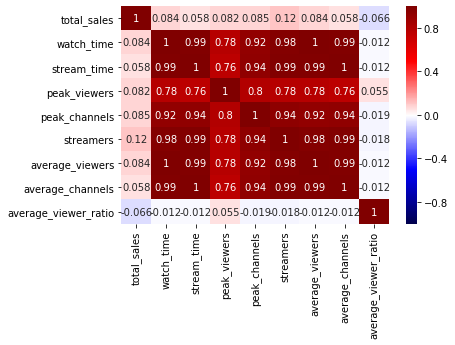

In [45]:
sns.heatmap(combined_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);


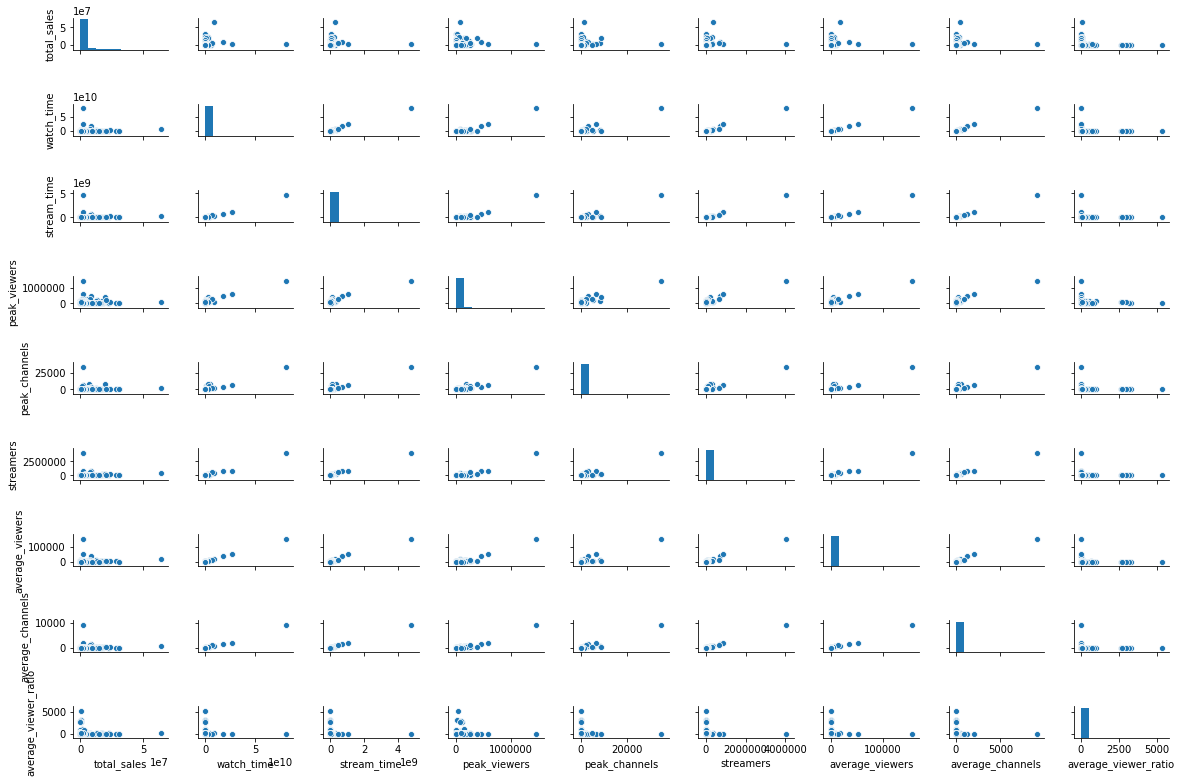

In [46]:
sns.pairplot(combined_df, height=1.2, aspect=1.5);

In [54]:
# Define the model
lm1 = smf.ols('total_sales ~ watch_time + stream_time + average_channels + average_viewers + peak_channels + peak_viewers + streamers', data=combined_df)

# Fit the model
fit = lm1.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_sales   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     36.86
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           1.97e-45
Time:                        00:09:45   Log-Likelihood:                -14873.
No. Observations:                 898   AIC:                         2.976e+04
Df Residuals:                     890   BIC:                         2.980e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.872e+06   3.17e+05      5.898      0.000    1.25e+06     2.5e+06
watch_time          -0.1772      0.814     -0.218      0.828      -1.775       1.421
stream_time          0.1499      0.851      0.176      0.860      -1.520       1.820
average_channels -1.372e+05   4.47e+05     -0.307      0.759   -1.01e+06     7.4e+05
average_viewers   9.394e+04   4.28e+05      0.220      0.826   -7.46e+05    9.34e+05
peak_channels      447.7645    309.285      1.448      0.148    -159.248    1054.777
peak_viewers       -13.6287      3.223     -4.228      0.000     -19.955      -7.303
streamers          100.1159      7.094     14.112      0.000      86.192     114.040
==============================================================================
Omnibus:                      786.049   Durbin-Watson:                   1.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28826.381
Skew:                           3.843   Prob(JB):                         0.00
Kurtosis:                      29.671   Cond. No.                     1.24e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [58]:
# Define the model
lm1 = smf.ols('total_sales ~ watch_time + stream_time', data=combined_df)

# Fit the model
fit2 = lm1.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_sales   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     16.78
Date:                Tue, 16 Jul 2019   Prob (F-statistic):           7.01e-08
Time:                        00:11:38   Log-Likelihood:                -14971.
No. Observations:                 898   AIC:                         2.995e+04
Df Residuals:                     895   BIC:                         2.996e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2.095e+06   1.41e+05     14.829      0.000    1.82e+06    2.37e+06
watch_time      0.0018      0.000      5.517      0.000       0.001       0.002
stream_time    -0.0303      0.006     -5.201      0.000      -0.042      -0.019
==============================================================================
Omnibus:                      954.761   Durbin-Watson:                   0.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            67193.823
Skew:                           5.006   Prob(JB):                         0.00
Kurtosis:                      44.178   Cond. No.                     3.00e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  3e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

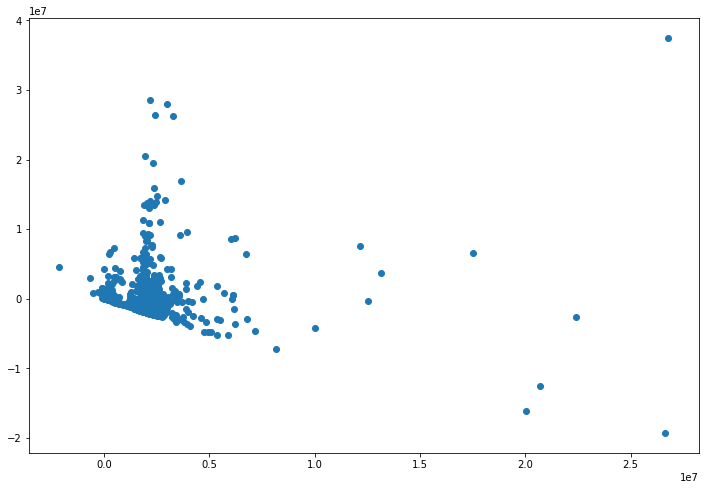

In [59]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(12,8))
plt.scatter(fit.predict(), fit.resid);